In [1]:
import re
from functools import reduce
from collections import Counter
from tqdm import tqdm

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.preprocessing import OrdinalEncoder

from datasets.fbp_dataset import FBPDataset
from datasets.fbp_dataset import load_texts
from datasets.processing_funcs import PIPELINE

nltk.download("stopwords")
plt.style.use('ggplot')
def color_map(idx: int) -> str:
    return list(rcParams['axes.prop_cycle'])[idx]['color']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zumo0\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
documents, tags = load_texts("./input/feedback-prize-2021/", PIPELINE, 1)
encoder = OrdinalEncoder()
label_unique = np.array(tags["discourse_type"].unique())
encoder.fit(label_unique.reshape(-1, 1))
dataset = FBPDataset(documents, tags, encoder, True)


Loading Dataset: 100%|██████████| 15594/15594 [01:33<00:00, 167.29it/s]


In [3]:
tags.sample(3)


,id,discourse_id,discourse_start,discourse_end,discourse_text,discourse_type,discourse_type_num,predictionstring,box_center,box_length
82970,C87561517810,1621197424865,1897,2073,driverless cars wouldn't be safe for society....,Concluding Statement,Concluding Statement 1,337 338 339 340 341 342 343 344 345 346 347 34...,0.888321,0.094505
73119,40FDE82C864D,1617253910979,247,1291,Sometimes a student turns in all of their work...,Evidence,Evidence 1,44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 5...,0.303977,0.416667
17065,066F06E5E52C,1619104772844,0,398,Summer can be a time for students to have fun ...,Lead,Lead 1,0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...,0.043311,0.085526


# General

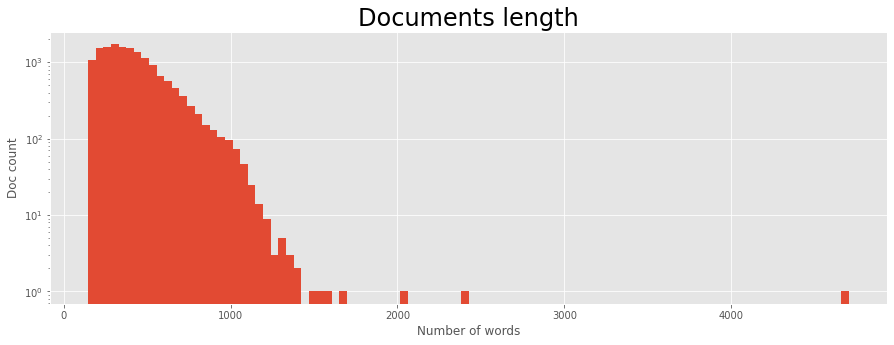

In [4]:
doc_len = documents.map(lambda x: len(x.split()))
plt.figure(figsize=(15, 5))
doc_len.hist(bins=100)
plt.yscale("log")
plt.title("Documents length", fontsize=24)
plt.xlabel("Number of words")
plt.ylabel("Doc count")
plt.savefig("figures/documents_length.pdf")
plt.show()

# Classes

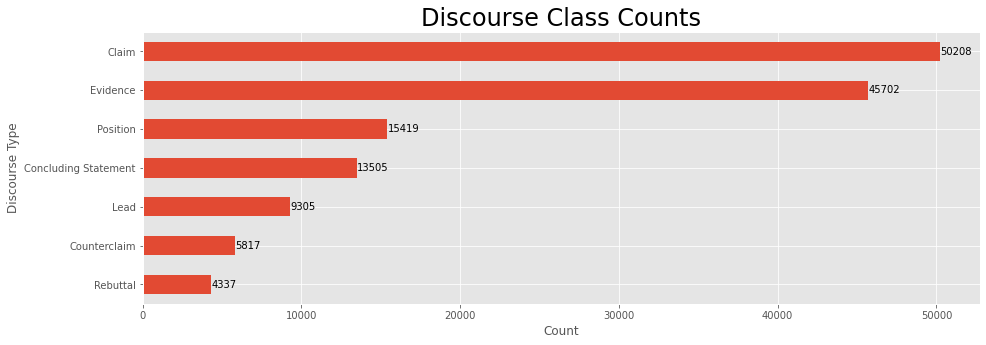

In [5]:
ax = (
    tags.groupby(by="discourse_type")[["id"]]
    .count()
    .sort_values("id")
    .plot(
        kind="barh",
        figsize=(15, 5),
        xlabel="Discourse Type",
        legend=False,
    )
)
assert isinstance(ax, plt.Axes)
ax.set_title("Discourse Class Counts", fontsize=24)
ax.set_xlabel("Count")
ax.bar_label(ax.containers[0], label_type="edge")
plt.savefig("figures/class_counts.pdf")
plt.show()


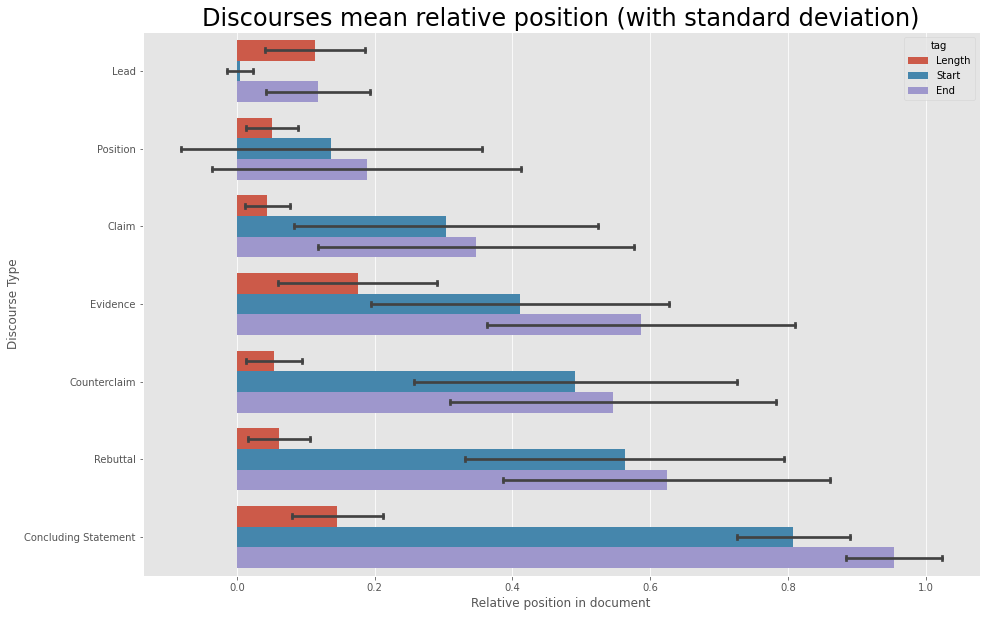

In [6]:
# Realive positions
tmp = tags[["discourse_type"]].copy()
tmp["discourse_len"] = tags["box_length"]
tmp["discourse_start"] = tags["box_center"] - tags["box_length"] / 2
tmp["discourse_end"] = tags["box_center"] + tags["box_length"] / 2

tmp_end = tmp[["discourse_type", "discourse_end"]].copy()
tmp_end.columns = ["discourse_type", "position"]
tmp_end["tag"] = "End"

tmp_start = tmp[["discourse_type", "discourse_start"]].copy()
tmp_start.columns = ["discourse_type", "position"]
tmp_start["tag"] = "Start"

tmp_len = tmp[["discourse_type", "discourse_len"]].copy()
tmp_len.columns = ["discourse_type", "position"]
tmp_len["tag"] = "Length"

tmp_cat = pd.concat([tmp_len, tmp_start, tmp_end])

plot_order = (
    tmp.groupby("discourse_type")["discourse_start"].mean().sort_values().index.values
)

plt.figure(figsize=(15, 10))
sns.barplot(
    x="position",
    y="discourse_type",
    hue="tag",
    data=tmp_cat,
    ci="sd",  # type: ignore
    capsize=0.05,
    order=plot_order,
)

plt.title("Discourses mean relative position (with standard deviation)", fontsize=24)
plt.ylabel("Discourse Type")
plt.xlabel("Relative position in document")
plt.savefig("figures/discourse_rel_pos.pdf")
plt.show()

# Gaps

In [7]:
all_gaps = []

for group_id, group in tags.groupby(by='id'):
    end = -1
    ordered = group.sort_values(by="discourse_start")
    for _, row in ordered.iterrows():
        init = row.discourse_start
        diff = init - end - 1
        end = row.discourse_end
        if diff > 0:
            all_gaps.append(diff)

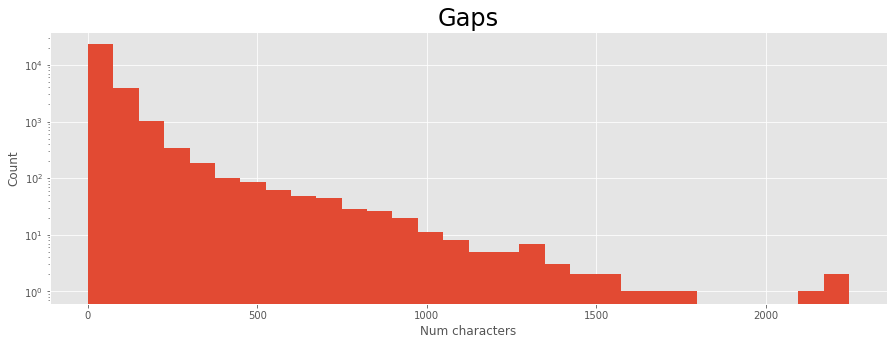

In [8]:
pd.Series(all_gaps).hist(bins=30, figsize=(15, 5))
plt.title("Gaps", fontsize=24)
plt.yscale("log")
plt.ylabel("Count")
plt.xlabel("Num characters")
plt.savefig("figures/gaps.pdf")
plt.show()

# Number of queries

In [9]:
grouped = tags.groupby(by="id")

arg_seg = np.zeros(len(grouped))
non_arg = np.zeros(len(grouped))
for j, (k, gp) in enumerate(grouped):
    arg_seg[j] = len(gp)
    for i in range(len(gp) - 1):
        pred_str1 = gp["predictionstring"].iloc[i].split()
        pred_str2 = gp["predictionstring"].iloc[i + 1].split()
        start = int(pred_str1[-1])
        end = int(pred_str2[0])
        if start + 1 != end:
            non_arg[j] += 1

seg = non_arg + arg_seg

print(f"The maximum number of units for document is : {int(np.max(seg))}")
print(f"The maximum number of argumentative units for document is : {int(np.max(arg_seg))}")


The maximum number of units for document is : 32
The maximum number of argumentative units for document is : 26


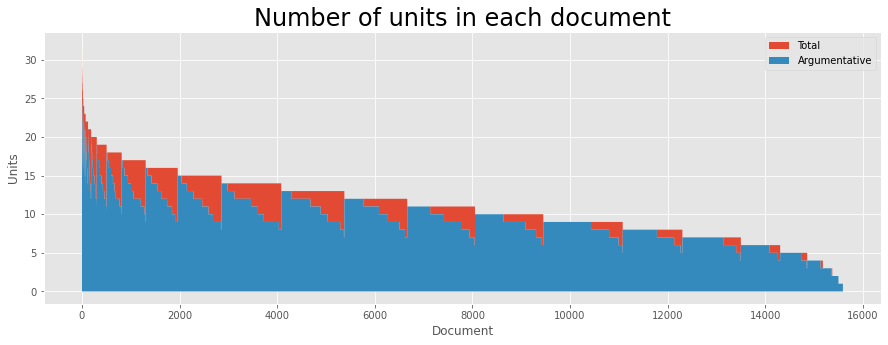

In [10]:
# Plot the distribution of the number of argumentative unit for each document
x = range(len(dataset))

idxs = np.flip(np.argsort(seg))
seg_sort = seg[idxs]
arg_seg_sort = arg_seg[idxs]
non_arg_sort = non_arg[idxs]

value = seg_sort[0]
new_idxs = np.empty_like(idxs)
start = 0
for end, val in enumerate(np.roll(seg_sort, -1), start=1):
    if val == value:
        continue
    to_sort = arg_seg_sort[start: end]
    s = np.flip(np.argsort(to_sort))
    new_idxs[start: end] = idxs[start: end][s]
    start = end
    value = val

seg_sort = seg[new_idxs]
arg_seg_sort = arg_seg[new_idxs]
non_arg_sort = non_arg[new_idxs]

plt.figure(figsize=(15, 5))
plt.fill_between(x, seg_sort, arg_seg_sort, label="Total")
plt.fill_between(x, arg_seg_sort, 0, label="Argumentative")
plt.xlabel("Document")
plt.ylabel("Units")
plt.title("Number of units in each document", fontsize=24)
plt.legend()
plt.savefig("figures/units_per_doc_count.pdf")
plt.show()

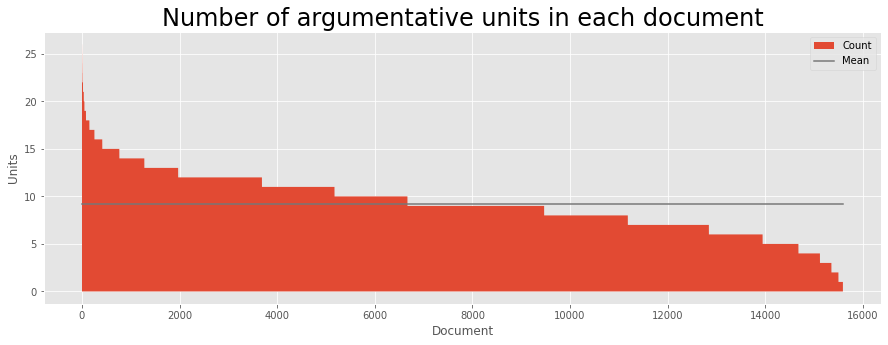

In [11]:
# Plot the distribution of the number of argumentative unit for each document
x = range(len(dataset))

idxs = np.flip(np.argsort(arg_seg))
arg_seg_sort = arg_seg[idxs]

plt.figure(figsize=(15, 5))
plt.fill_between(x, arg_seg_sort, 0, label="Count")
plt.plot((x[0], x[-1]), [arg_seg.mean()] * 2, c=color_map(3), label="Mean")
plt.xlabel("Document")
plt.ylabel("Units")
plt.legend()
plt.title("Number of argumentative units in each document", fontsize=24)
plt.savefig("figures/arg_units_per_doc_count.pdf")
plt.show()

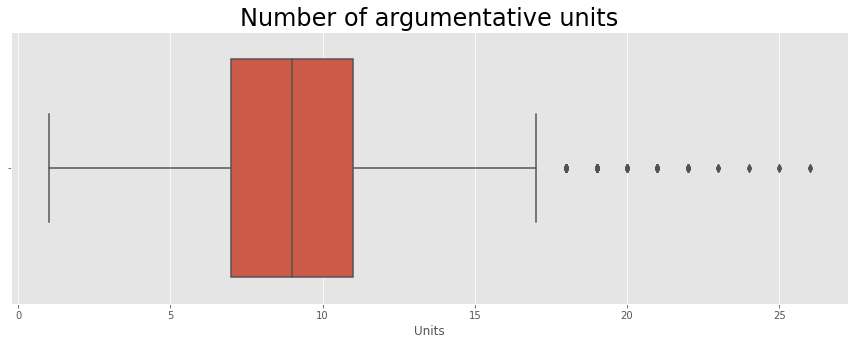

In [16]:
plt.figure(figsize=(15, 5))
sns.boxplot(x = arg_seg)
plt.xlabel("Units")
plt.title("Number of argumentative units", fontsize=24)
plt.savefig("figures/arg_units_per_doc_boxplot.pdf")
plt.show()

# Class Correlation

In [169]:
REPLACE_BY_SPACE_RE = re.compile("[.,;!?']")
STOPWORDS = set(nltk.corpus.stopwords.words("english"))


def remove_stopwords(text: str) -> str:
    return " ".join([x for x in text.split() if x and x not in STOPWORDS])


def replace_special_characters(text: str) -> str:
    return REPLACE_BY_SPACE_RE.sub(" ", text)


NEW_PIPELINE = PIPELINE + [replace_special_characters, remove_stopwords]


def get_words(gp):
    group = gp["discourse_text"]
    words = []
    for i in range(len(group)):
        words += reduce(lambda txt, f: f(txt), NEW_PIPELINE, group.iloc[i]).split()
    return words

In [195]:
counted = {key: Counter(get_words(gp)) for key, gp in tags.groupby(by="discourse_type")}
labels = list(counted.keys())
word_list = list(set().union(*[set(counts.keys()) for counts in counted.values()]))

tot_word_class = np.array([sum(c for c in counted[k].values()) for k in labels])
def correlation(word: str) -> np.ndarray:
    """Term Frequency in each class * inverse word frequency"""
    num_word_class = np.array([counted[key].get(word, 0) for key in labels])
    tf = num_word_class / tot_word_class
    iwf = np.log10(len(word_list) /(1 + sum(num_word_class)))
    return tf * iwf

matrix = np.zeros((len(word_list), len(labels)))
for i, w in enumerate(word_list):
    matrix[i, :] = correlation(w)

weights = pd.DataFrame(matrix, columns=labels, index=word_list)

summary = (
    weights.copy()
    .assign(order=weights.max(axis=1))
    .sort_values("order", ascending=False)
    .drop("order", axis=1)
    .loc[(weights == weights.max()).any(axis=1)]
)

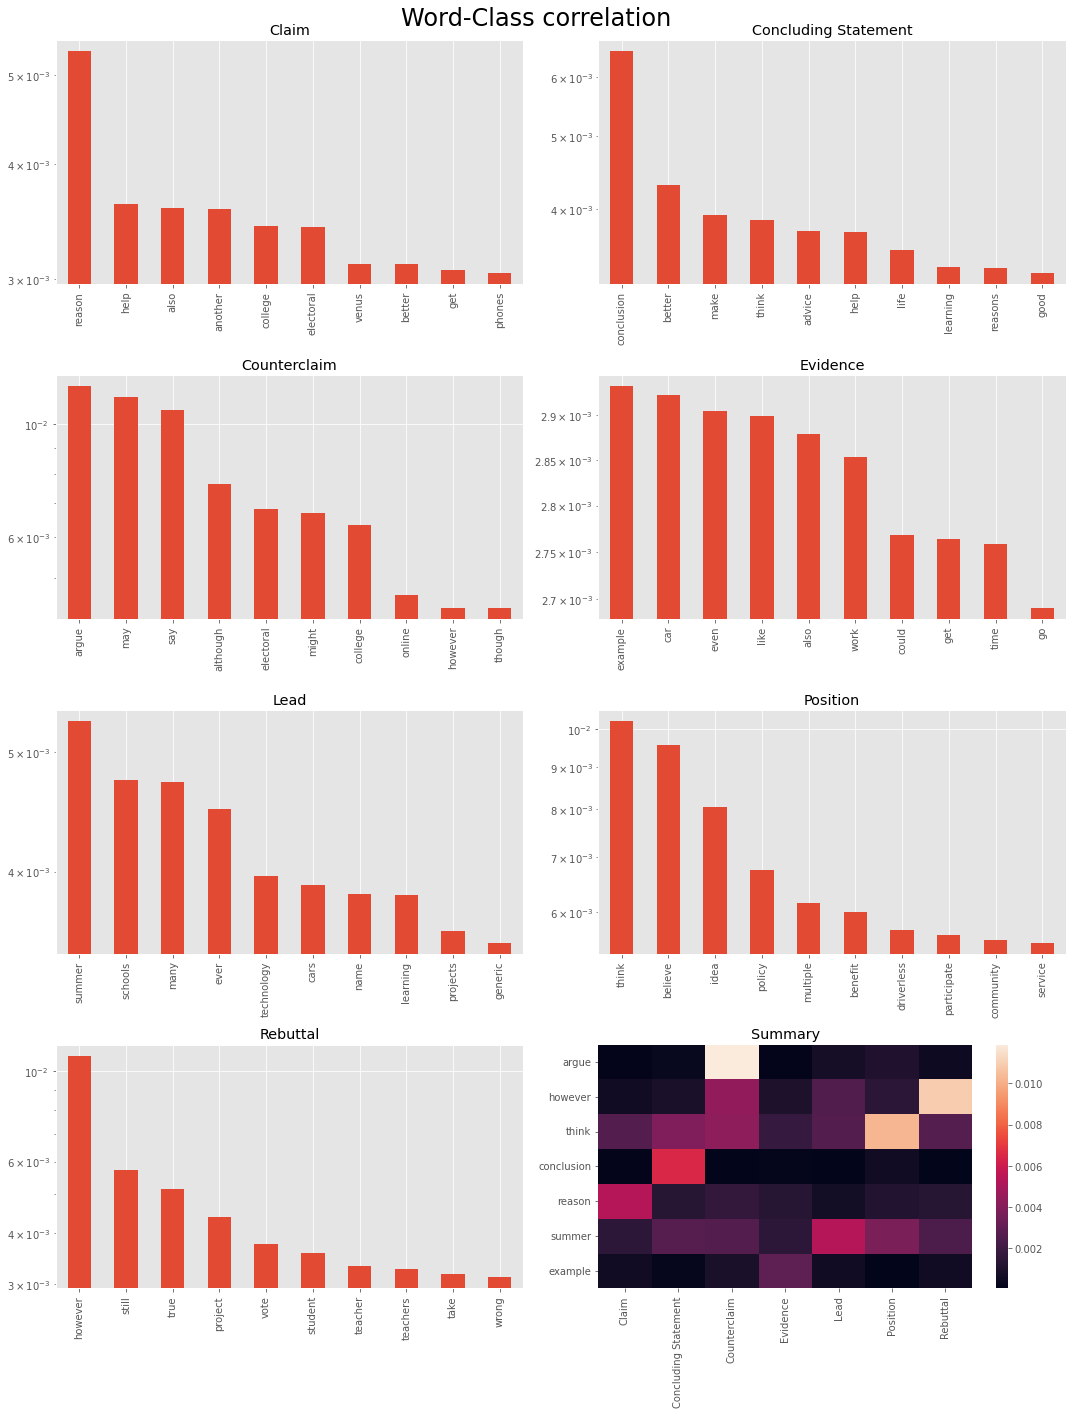

In [199]:
axs: "tuple[tuple[plt.Axes, ...], ...]"
fig, axs = plt.subplots(4, 2, figsize=(15, 20)) # type: ignore

for i, col in enumerate(weights.columns):
    ax = axs[i//2][i%2]
    df = weights[[col]].sort_values(by=[col], ascending=False)
    df = df[col].head(10).plot(kind="bar", title=col, ax=ax)
    ax.set_yscale("log")

sns.heatmap(summary, ax=axs[3][1])
axs[3][1].set_title("Summary")
fig.suptitle("Word-Class correlation", fontsize=24)
fig.tight_layout()
plt.savefig("figures/word_class_correlation.pdf")
plt.show()

# OOV

In [ ]:
from models.detr import PrepareInputs
from transformers import LongformerTokenizerFast  # type: ignore

tokenizer = PrepareInputs(
    tokenizer=LongformerTokenizerFast.from_pretrained("allenai/longformer-base-4096") # type: ignore
)

# End